In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/bensonmanner/Desktop/ACME/WebbResearch/Projects/Optimization/delay-optimizer')
import os
import json
from Optimizer_Scripts.learning_rate_generator import generate_learning_rates
from Optimizer_Scripts.param_optimizer_helper import test_builder
from Optimizer_Scripts import Delayer
from Optimizer_Scripts import optimizers 
from Optimizer_Scripts import functions

# Helper Functions

In [66]:
def run_single_start(delayer, x_init, maxiter=1000, tol=1e-5, use_delays=True):
    delayer.x_init = x_init
    delayer.compute_time_series(tol=tol, maxiter=maxiter, use_delays=use_delays)
    return delayer


def set_axis_attributes(ax, plot_dims):
    for it, (dim_0, dim_1) in enumerate(plot_dims):
        axis = ax[it]
        axis.set_xlabel("Dimension {}".format(dim_0))
        axis.set_ylabel("Dimension {}".format(dim_1))
        axis.set_xlim([-32.,32.])
        axis.set_ylim([-32.,32.])
        
    
def plot_values(axis, value, vmax=25.0, vmin=0.0, time_plot=False, cmap='winter'):
    #plot the results according to the given delayer
    color = 'r'
    if cmap == 'winter':
        color = 'b'
    if vmin > 0:
        vmin = 0
    if (time_plot is True):
        value[2] = np.flip(np.arange(1,len(value[2])+1,1))
        vmin = 0
        vmax = len(value[2])
        axis.plot(value[0], value[1], color=color, alpha=0.3)
    im = axis.scatter(value[0], value[1],c=value[2], vmin=vmin, vmax=vmax, alpha=0.01, cmap=cmap, s=100)
    return im
    
    
def add_new_values(value, dim_tuple, delayer, type_plot):
    value[0] += delayer.time_series[1:,dim_tuple[0]].tolist()
    value[1] += delayer.time_series[1:,dim_tuple[1]].tolist()
    if (type_plot == 'loss'):
        value[2] += delayer.loss_list
    elif (type_plot == 'gradient'):
        value[2] += delayer.grad_list
    max_val = max(value[2])
    min_val = min(value[2])
    return value, max_val, min_val 

    
def create_grid(range_grid, num_points, n):
    x = np.linspace(range_grid[0], range_grid[1], num_points)
    #create the mesh
    list_xs = [x for i in range(n)]
    grid = itertools.product(*list_xs)
    return grid


def plot_colorbar(fig, axis, image):
    colorbar = fig.colorbar(image, ax=axis)
    colorbar.set_alpha(1)
    colorbar.draw_all()
    

def plot_results(plot_dims, values, vmax, vmin, finals, fig, ax, colorbar=True, use_both=False, time_plot=False):
    #now plot on each axis in the list of axes
    alpha_hist = 1.0
    finals_del = None
    if (use_both is True):
        values, values_del = values
        vmax, vmax_del = vmax
        vmin, vmin_del = vmin
        finals, finals_del = finals
        alpha_hist = 0.3
        
    for it in range(len(plot_dims)):
        axis = ax[it]
        #plot the other plot if use both is true
        if (use_both is True):
            im1 = plot_values(axis, values_del[it], vmax=vmax_del, vmin=vmin_del, cmap='autumn', time_plot=time_plot)      
        im = plot_values(axis, values[it], vmax=vmax, vmin=vmin, time_plot=time_plot)
        if (colorbar is True):
            plot_colorbar(fig, axis, im)     
    ax[-1].hist(finals, alpha=alpha_hist, color='b')
    ax[-1].set_title("Final Values")
    #plot the delayed finals if we did both
    if finals_del is not None:
        ax[-1].hist(finals_del, alpha=alpha_hist, color='r')

        
def calculate_save_values(delayer, initials, plot_dims, maxiter, tol, use_delays, gen_params, type_plot):
    #plot the results according to the given dimensions
    values = [[[], [], []] for i in range(len(plot_dims))]
    finals = list()
    total_min = np.inf
    total_max = -np.inf
    #get the relevant variables from the delayer
    loss, grad, params, n = delayer.loss_function, delayer.grad, delayer.Optimizer.params, delayer.n
    max_L, num_delays = delayer.max_L, delayer.num_delays
    for x_init in initials:
        x_init = np.asarray(x_init)
        delayer = run_single_start(delayer, x_init, maxiter, tol, use_delays)
        for it in range(len(values)):
            dim_tuple = plot_dims[it]
            value = values[it]
            values[it], max_val, min_val = add_new_values(value, dim_tuple, delayer, type_plot)
            if (max_val > total_max):
                total_max = max_val
            if (min_val < total_min):
                total_min = min_val
        finals.append(delayer.final_val)
        #recreate the delayer to reset the learning rate generater
        del delayer
        params['learning_rate'] = generate_learning_rates(False, gen_params)
        optim = optimizers.Adam(params)
        delayer = Delayer.Delayer(n, optim, loss, grad, max_L=max_L, 
                                  num_delays=num_delays, compute_loss=True,
                                  save_grad=True)
    return values, finals, max_val, min_val, delayer

        
def initialize_optimizer(optimizer='Adam', loss='Ackley', n=2, max_L=1, num_delays=1000):
    #get the loss and gradients
    loss=functions.ackley_gen(n)
    grad=functions.ackley_deriv_gen(n)
    #create the optimizer
    max_L=max_L
    num_delays=num_delays
    params=dict()
    params['beta_1'] = 0.9
    params['beta_2'] = 0.999
    gen_params = {'step_size': 740, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
    params['learning_rate'] = generate_learning_rates(False, gen_params)
    optim = optimizers.Adam(params)
    delayer = Delayer.Delayer(n, optim, loss, grad, max_L=max_L, 
                              num_delays=num_delays, compute_loss=True,
                              save_grad=True)
    return delayer, gen_params
    
    
def optimizer_path_tracker(range_grid=[-32.,32.], num_points=100, maxiter=2000, tol=1e-5,
                use_delays=True, n=1000, plot_dims=[(0,1),(2,6), (0,10), (61,78)], type_test='random',
                do_both=False, num_delays=1000, max_L=1, type_plot='loss', colorbar=True, time_plot=False):
    #the different types of initial values
    if type_test == 'random':
        initials = np.random.uniform(range_grid[0], range_grid[1], size=(num_points,n))
    elif type_test == 'grid':
        initials = create_grid(range_grid, num_points, n)
    elif type_test == 'same':
        initials = np.random.uniform(range_grid[0], range_grid[1], size=n)
        initials = np.tile(initials, (num_points, 1))
    #initalize optimizer and parameters
    delayer, gen_params = initialize_optimizer(n=n, max_L=max_L, num_delays=num_delays)
    #plot the results on a loss/dimension scatter plot
    title = "{}: {} Optimizer: {} Dimensions: {} is max delay".format('Ackley', delayer.Optimizer.name, delayer.n, delayer.max_L)
    fig,ax=plt.subplots(len(plot_dims)+1,1,figsize=(10,8*(len(plot_dims)+1)))
    #now make ax a list if it is not already
    if type(ax) is not np.ndarray:
        ax = np.array([ax])
    #set the labels on the axes
    set_axis_attributes(ax,plot_dims)
    #calculate the relavant values
    if (do_both is False):
        values, finals, vmax, vmin, delayer = calculate_save_values(delayer, initials, plot_dims, maxiter, 
                                                           tol, use_delays, gen_params, type_plot)
    else:
        values_del, finals_del, vmax_del, vmin_del, delayer = calculate_save_values(delayer, initials, plot_dims,
                                                                           maxiter, tol, True, 
                                                                           gen_params, type_plot)
        values, finals, vmax, vmin, delayer = calculate_save_values(delayer, initials, plot_dims, maxiter, 
                                                           tol, False, gen_params, type_plot)
        values, finals, vmax, vmin = (values, values_del), (finals, finals_del), (vmax, vmax_del), (vmin, vmin_del)
        
    del delayer
    plot_results(plot_dims, values, vmax, vmin, finals, fig, ax, colorbar=colorbar, 
                 use_both=do_both, time_plot=time_plot)
    fig.suptitle(title)
    plt.show()

#  2 Dimensional Grid Loss Test

### Undelayed Optimal Parameters Test

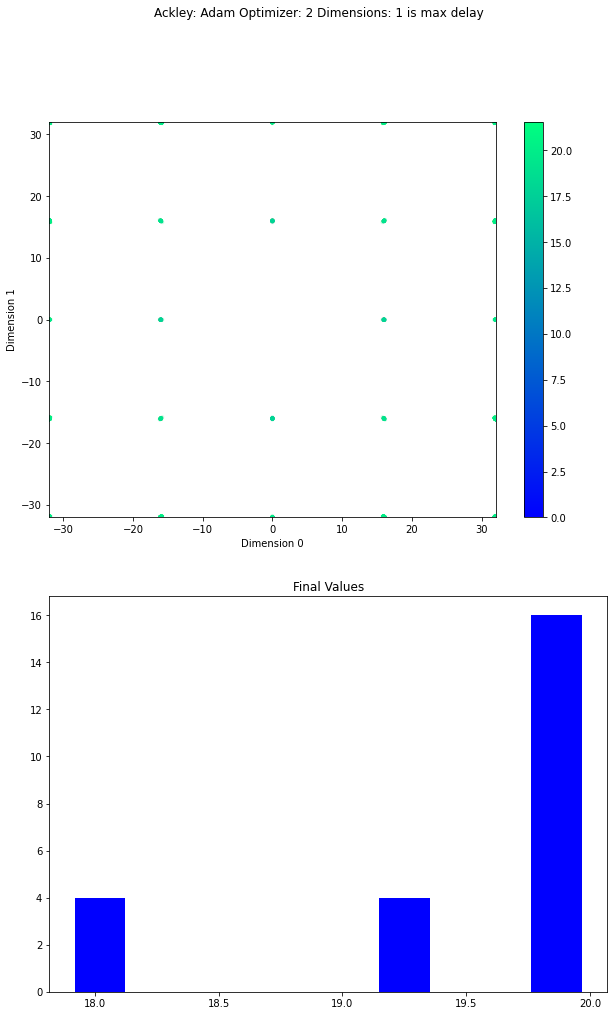

In [117]:
optimizer_path_tracker(num_points=5, use_delays=False, plot_dims=[(0,1)], type_test='grid', n=2)

### Delayed Optimal Parameters Test

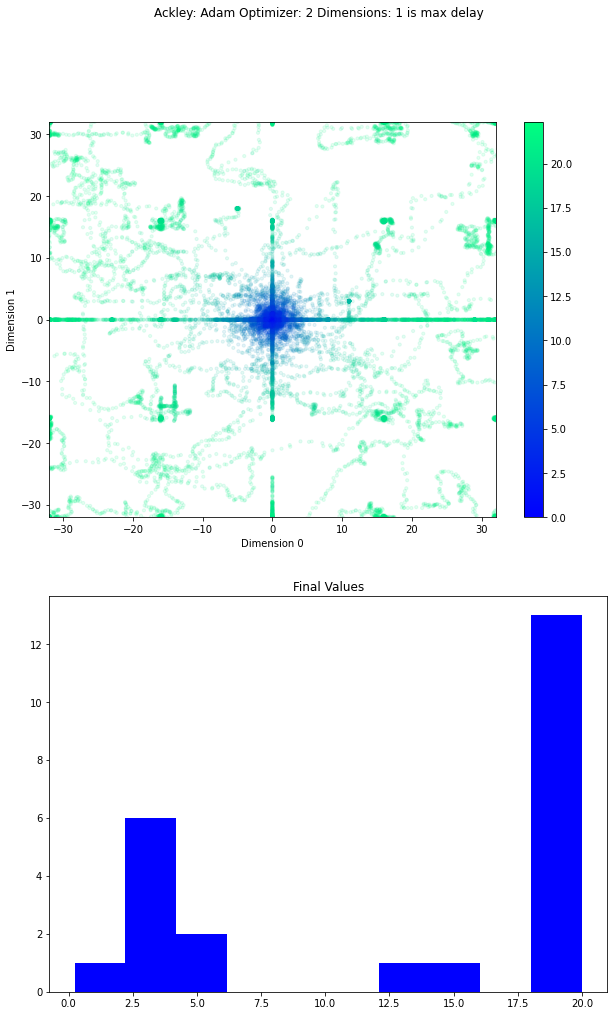

In [50]:
optimizer_path_tracker(num_points=5, use_delays=True, type_test='grid', n=2, plot_dims=[(0,1)])

# 1000 Dimensional Loss Test

### Randomly Generate Initial Points - Delayed

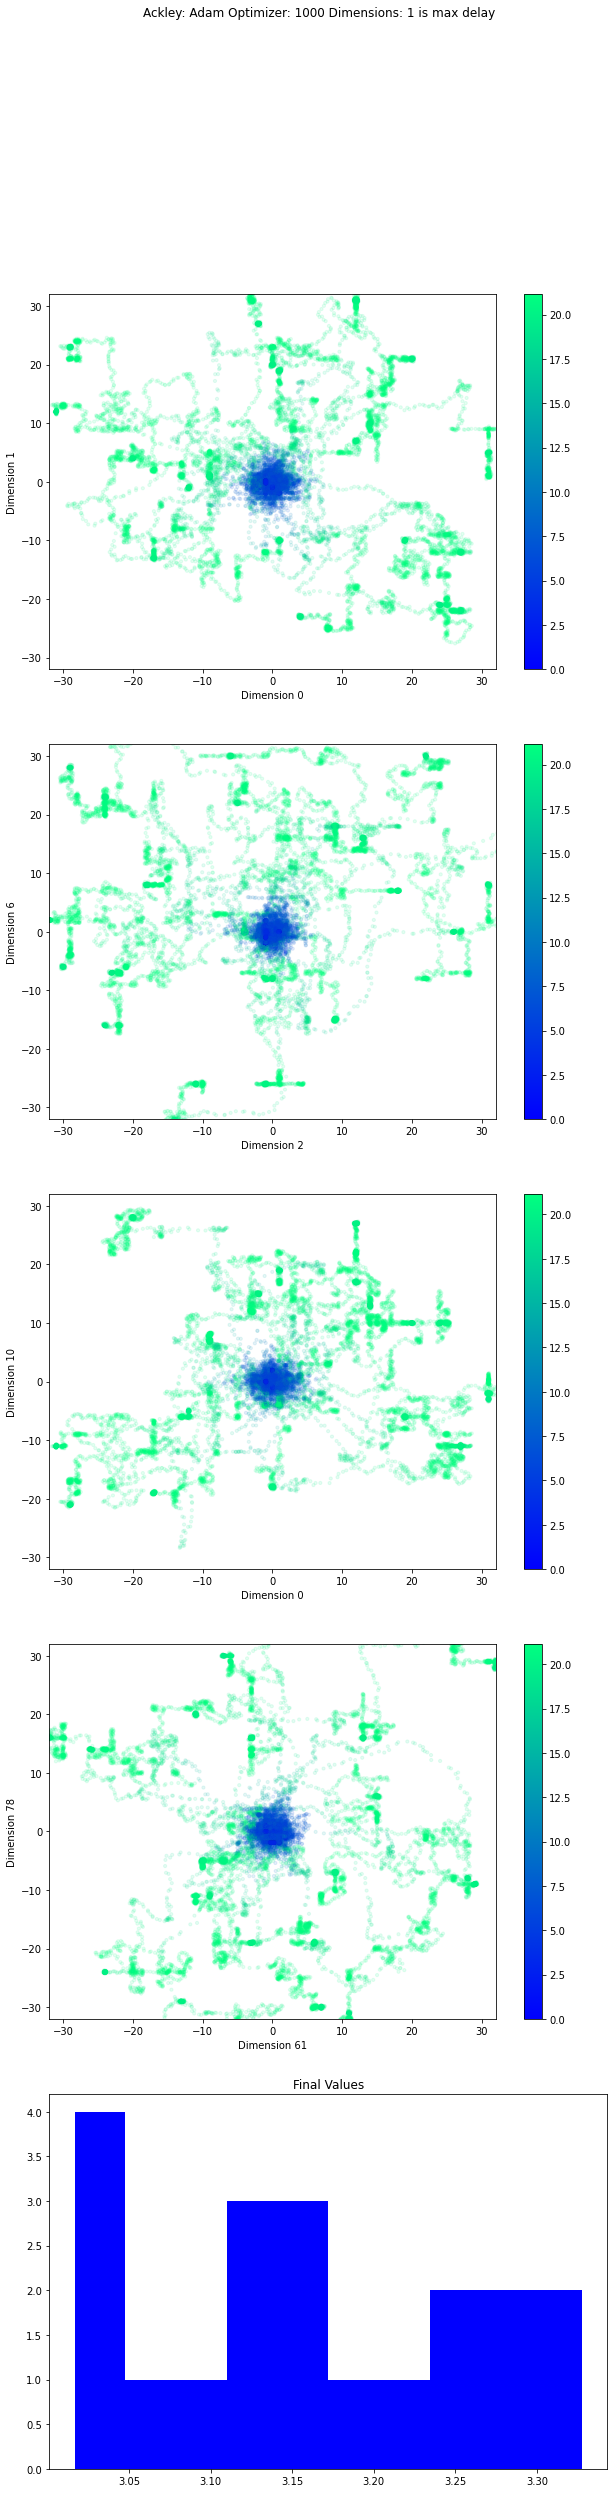

In [51]:
optimizer_path_tracker(num_points=20)

### Randomly Generate Initial Points - UnDelayed

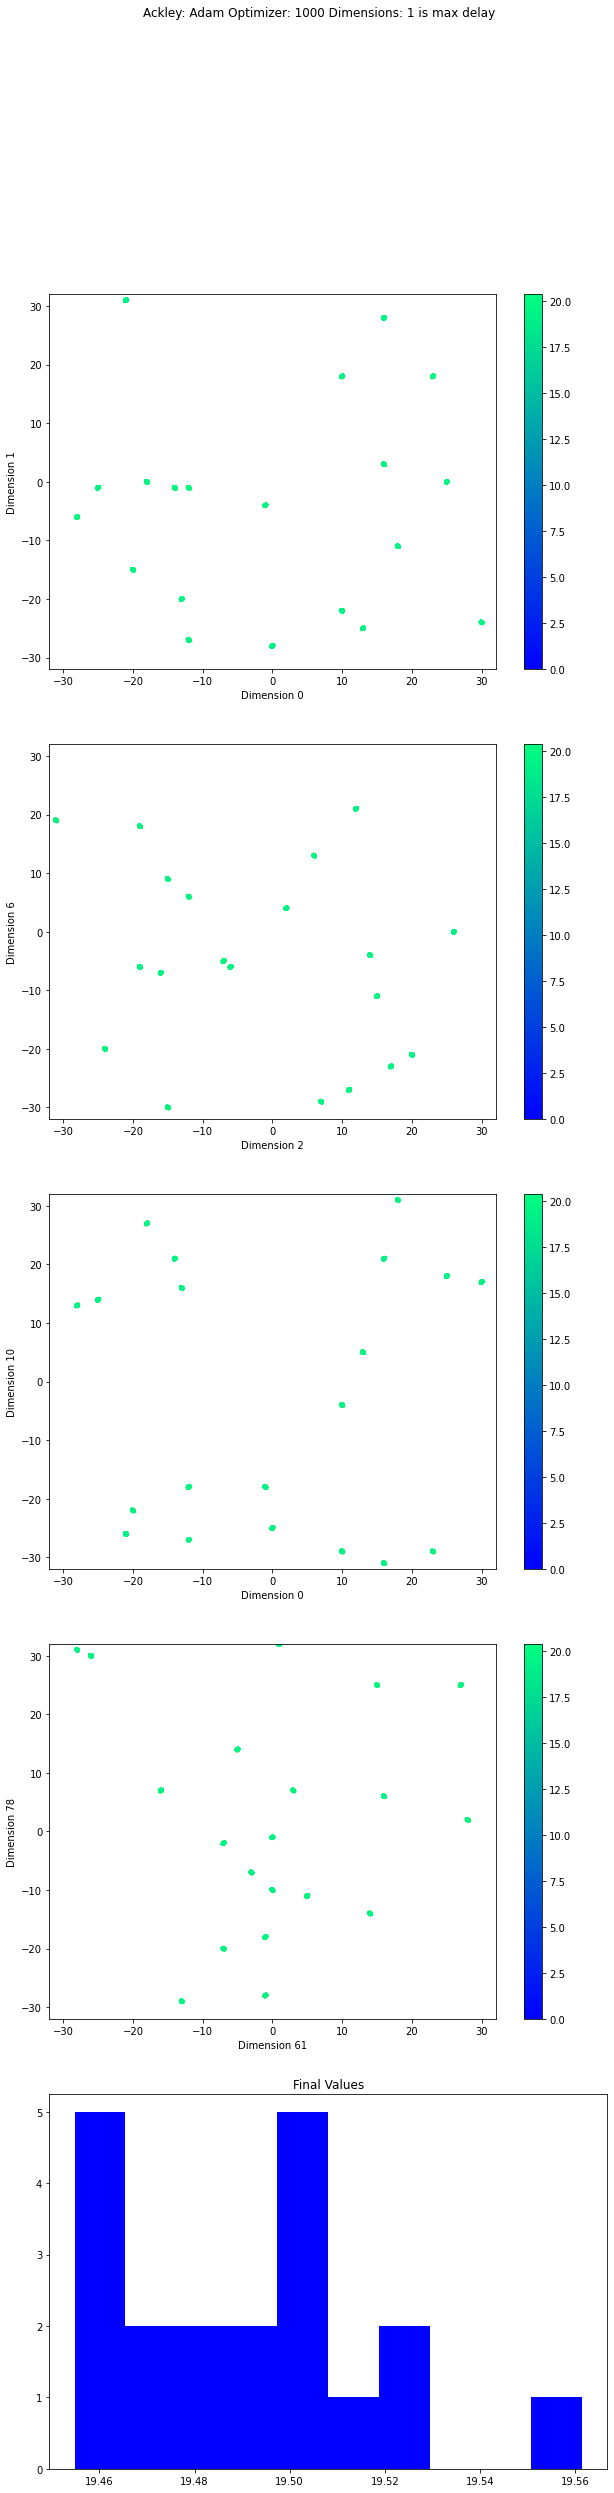

In [52]:
optimizer_path_tracker(use_delays=False, num_points=20)

# 10000 Dimensional Loss Test

### Delayed

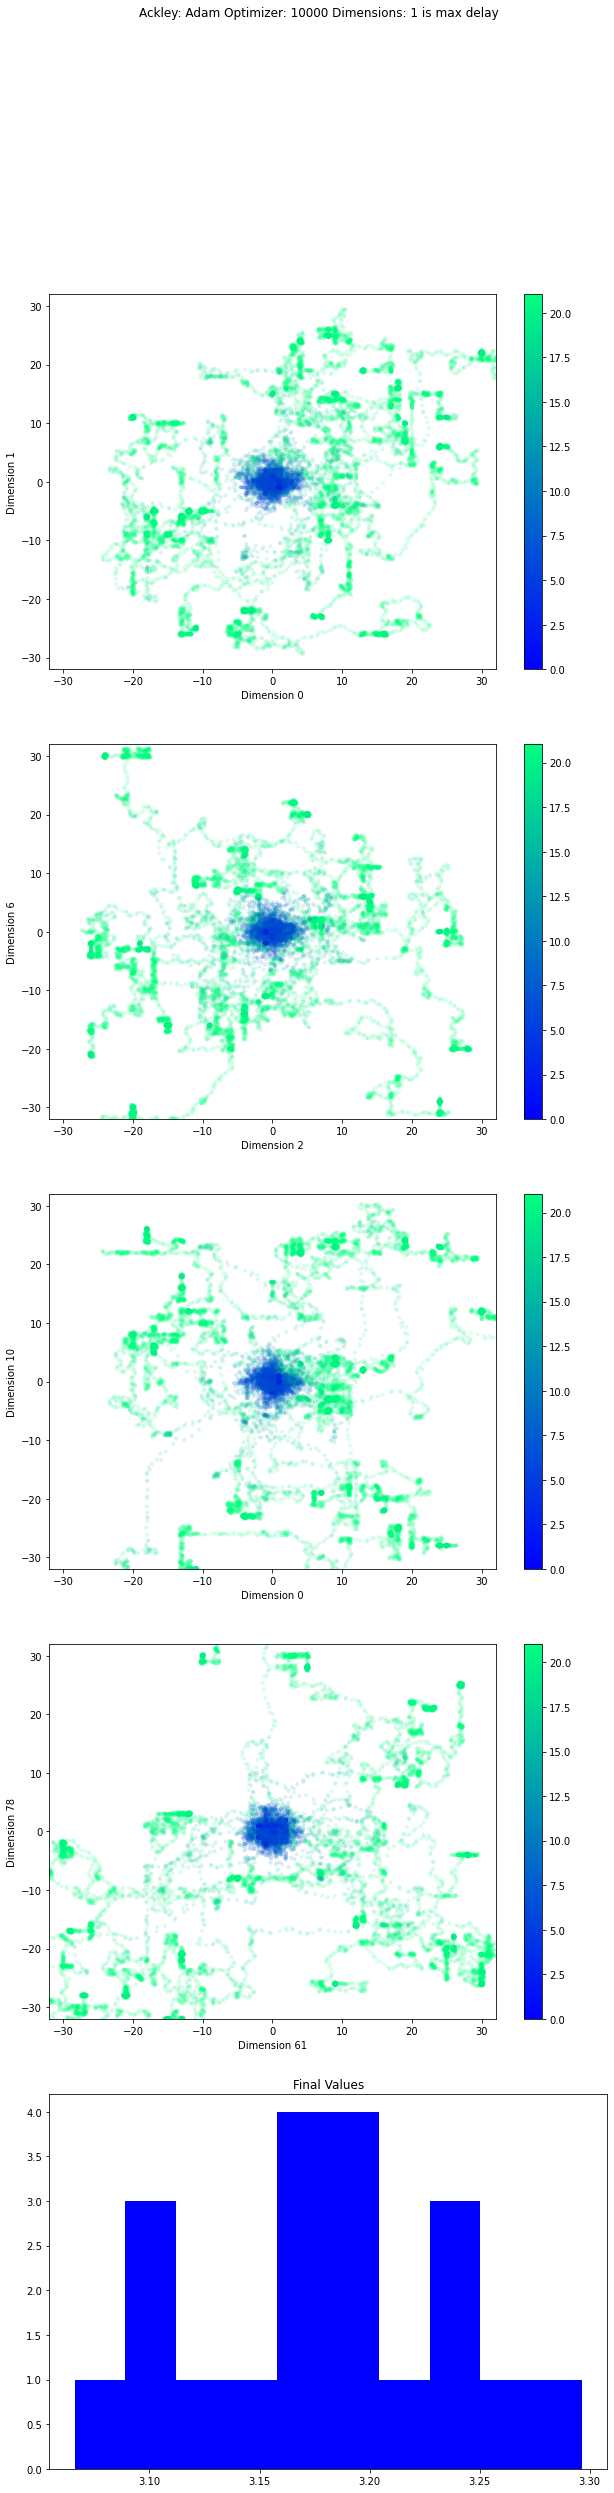

In [53]:
optimizer_path_tracker(n=10000, num_points=20)

### Undelayed

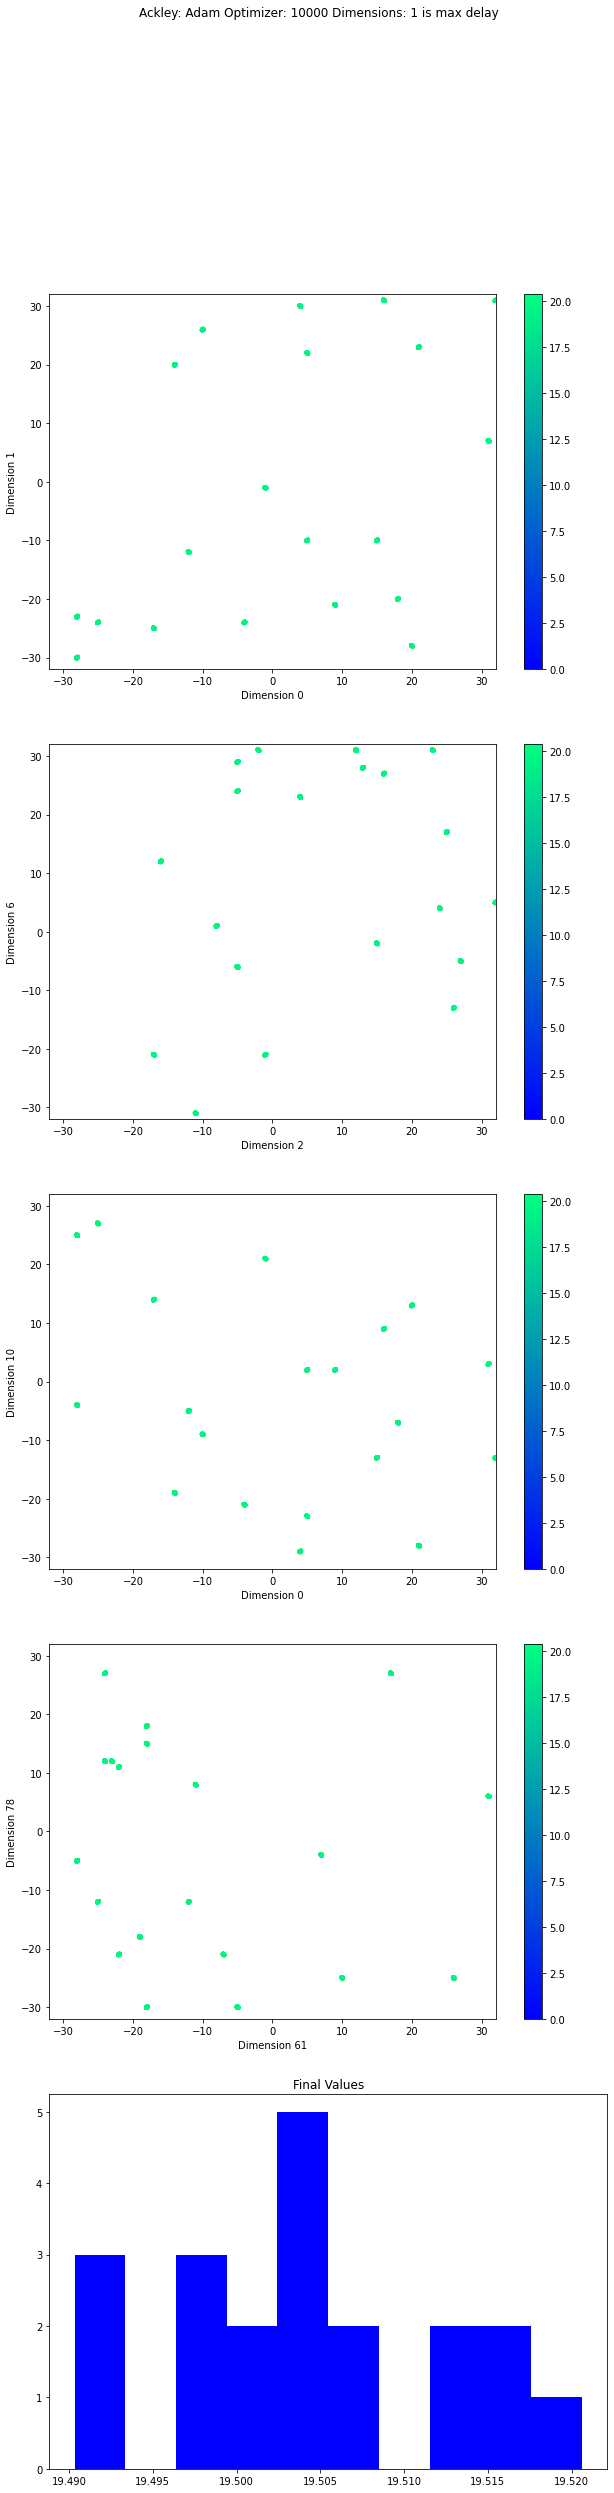

In [54]:
optimizer_path_tracker(n=10000, use_delays=False, num_points=20)

# 2 Dimensions Grid Gradient

### Undelayed

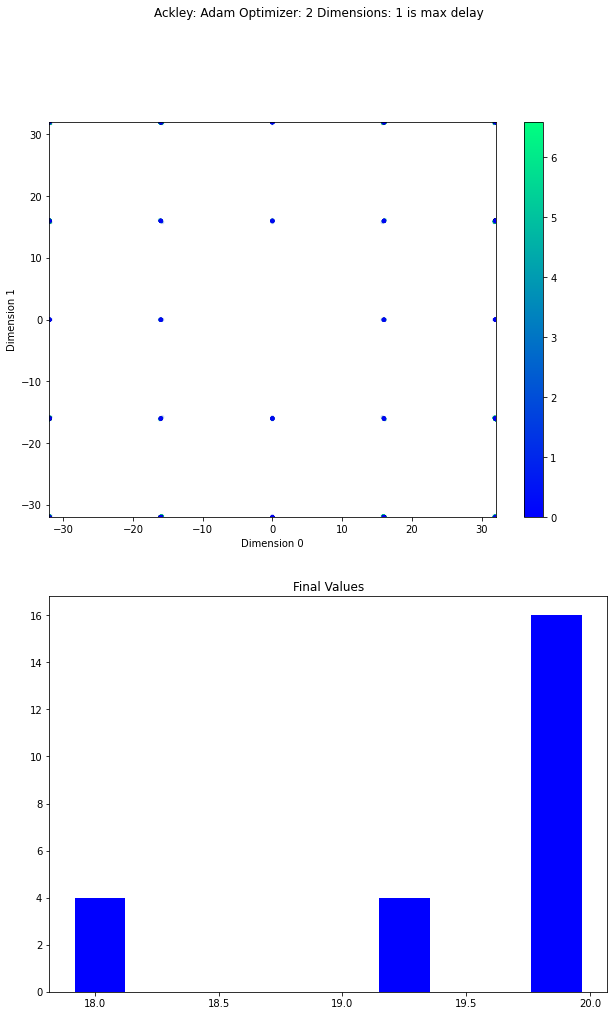

In [55]:
optimizer_path_tracker(num_points=5, use_delays=False, plot_dims=[(0,1)], type_test='grid', n=2, type_plot='gradient')

### Delayed

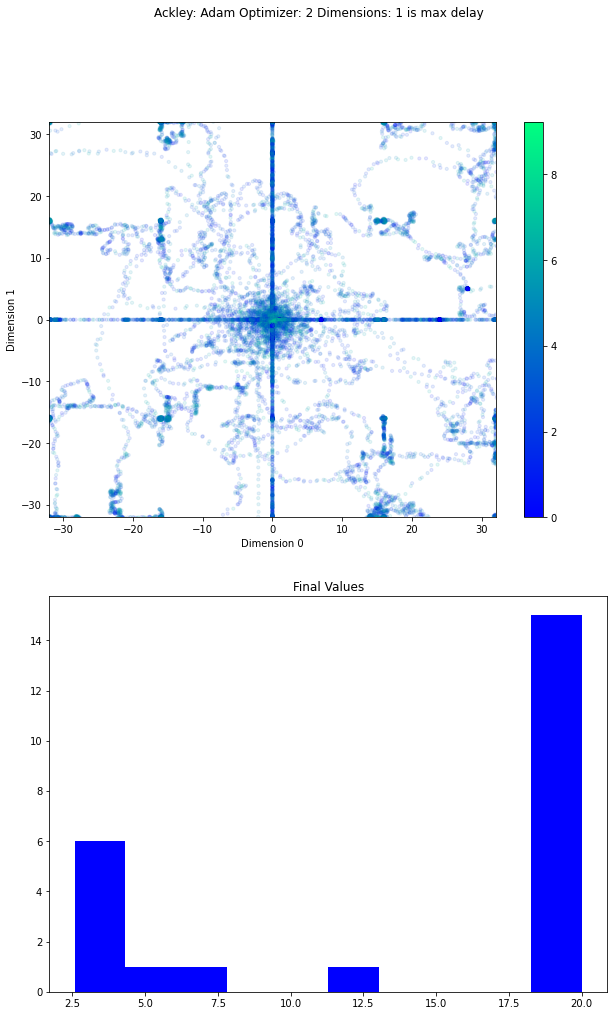

In [56]:
optimizer_path_tracker(num_points=5, use_delays=True, plot_dims=[(0,1)], type_test='grid', n=2, type_plot='gradient')

### Undelayed

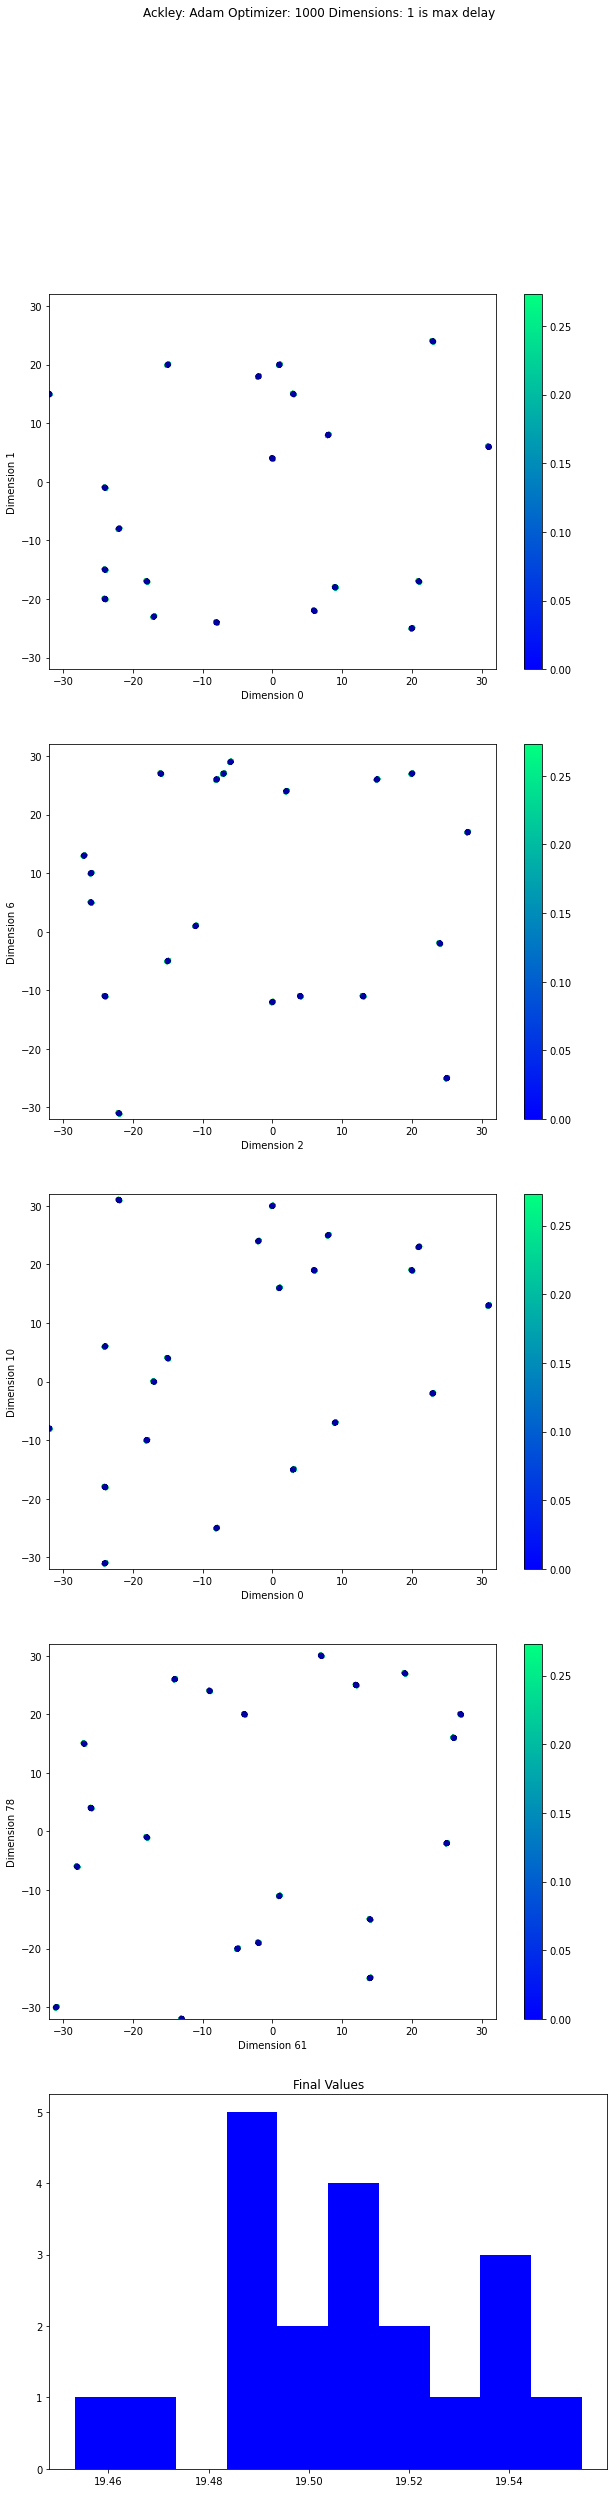

In [60]:
optimizer_path_tracker(num_points=20, use_delays=False, type_test='random', n=1000, type_plot='gradient')

### Delayed

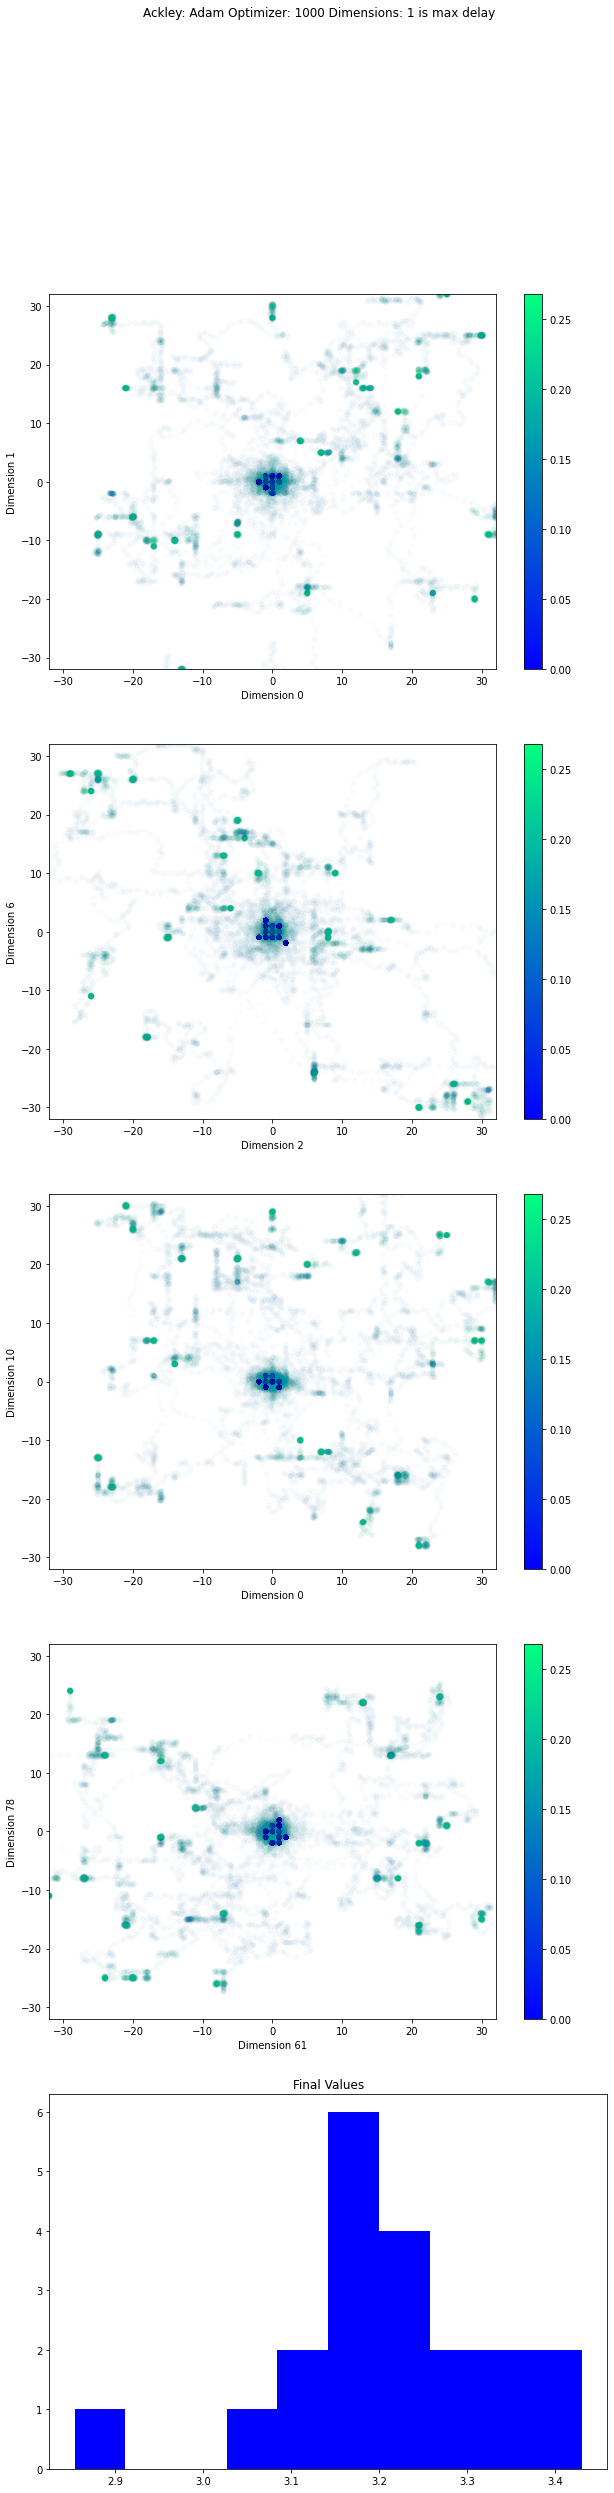

In [59]:
optimizer_path_tracker(num_points=20, use_delays=True, type_test='random', n=1000, type_plot='gradient')

# Plots Over Time Test

2


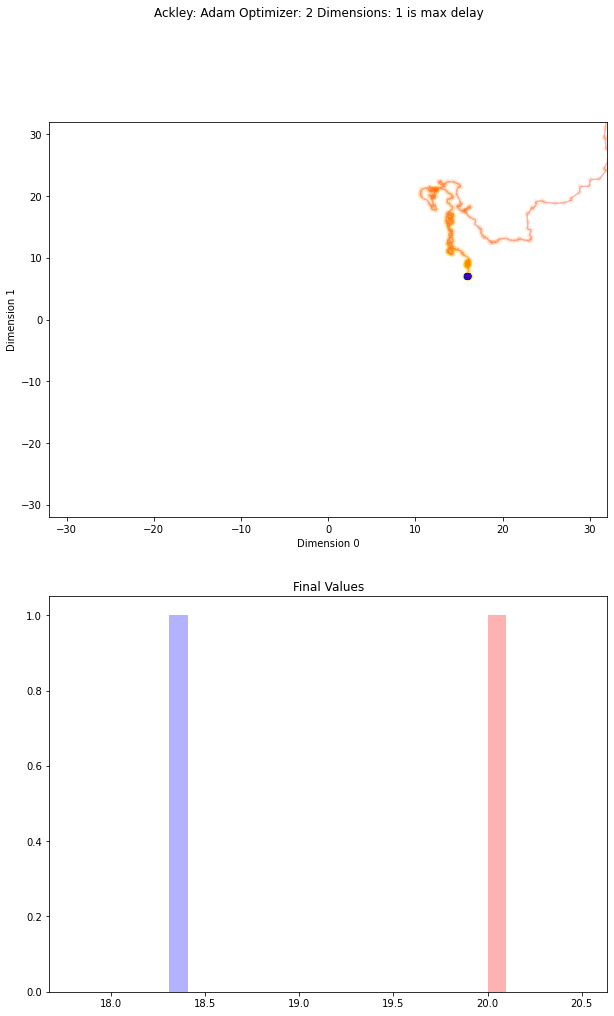

In [35]:
optimizer_path_tracker(num_points=1, do_both=True, plot_dims=[(0,1)], type_test='random', n=2, type_plot='loss', colorbar=False, time_plot=True)

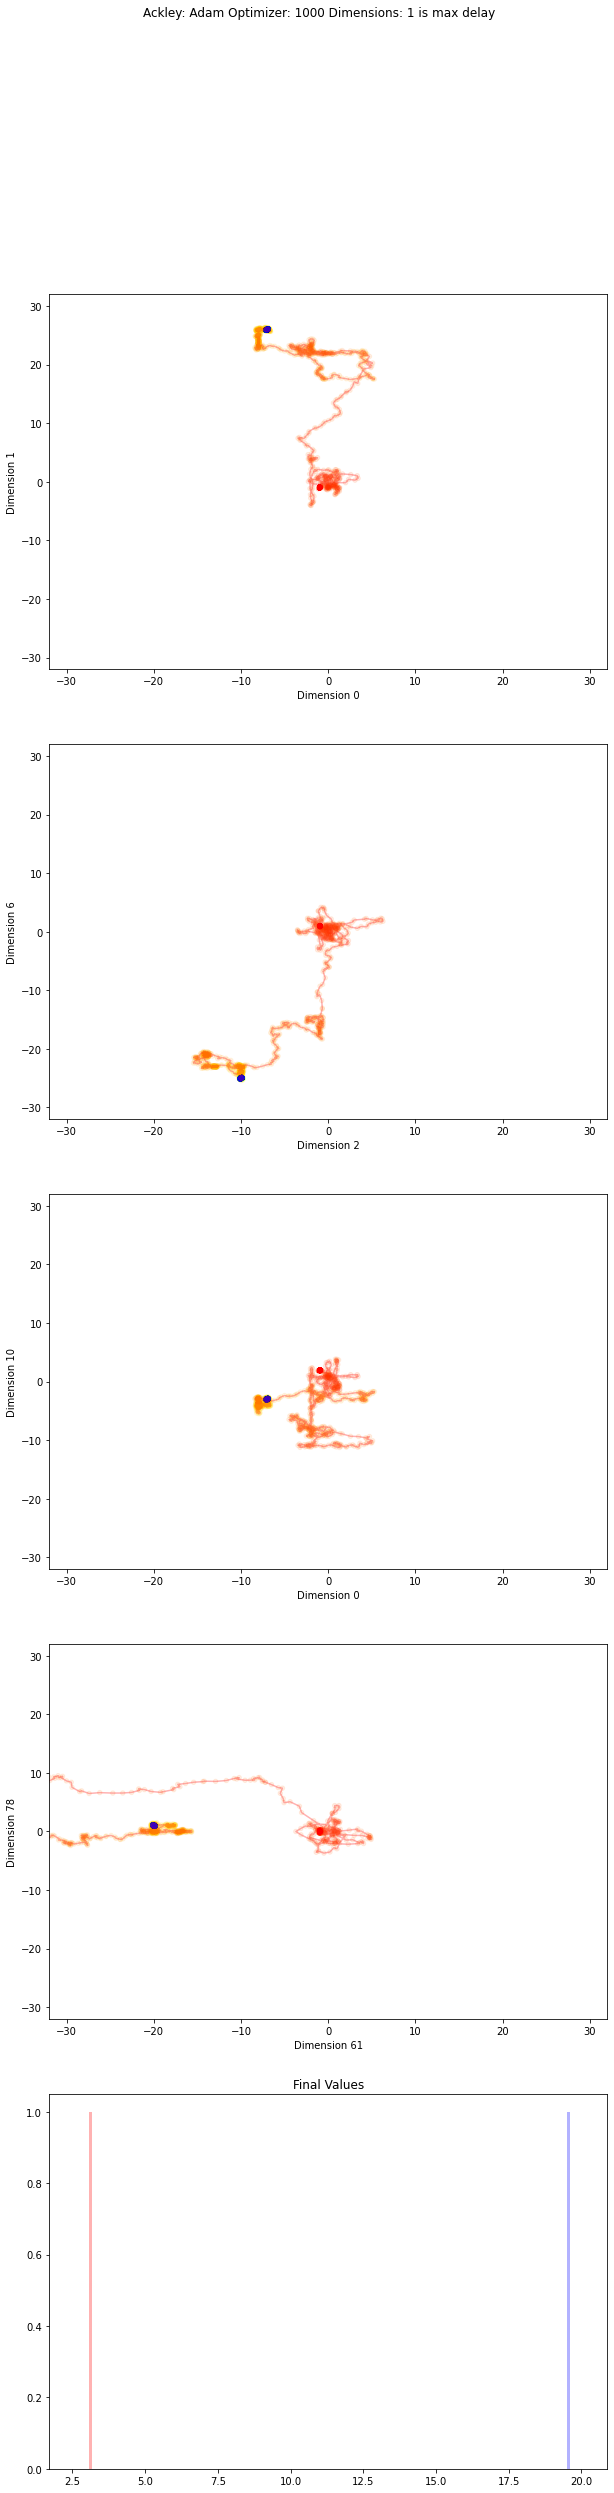

In [40]:
optimizer_path_tracker(num_points=1, do_both=True, type_test='random', n=1000, type_plot='loss', colorbar=False, time_plot=True)

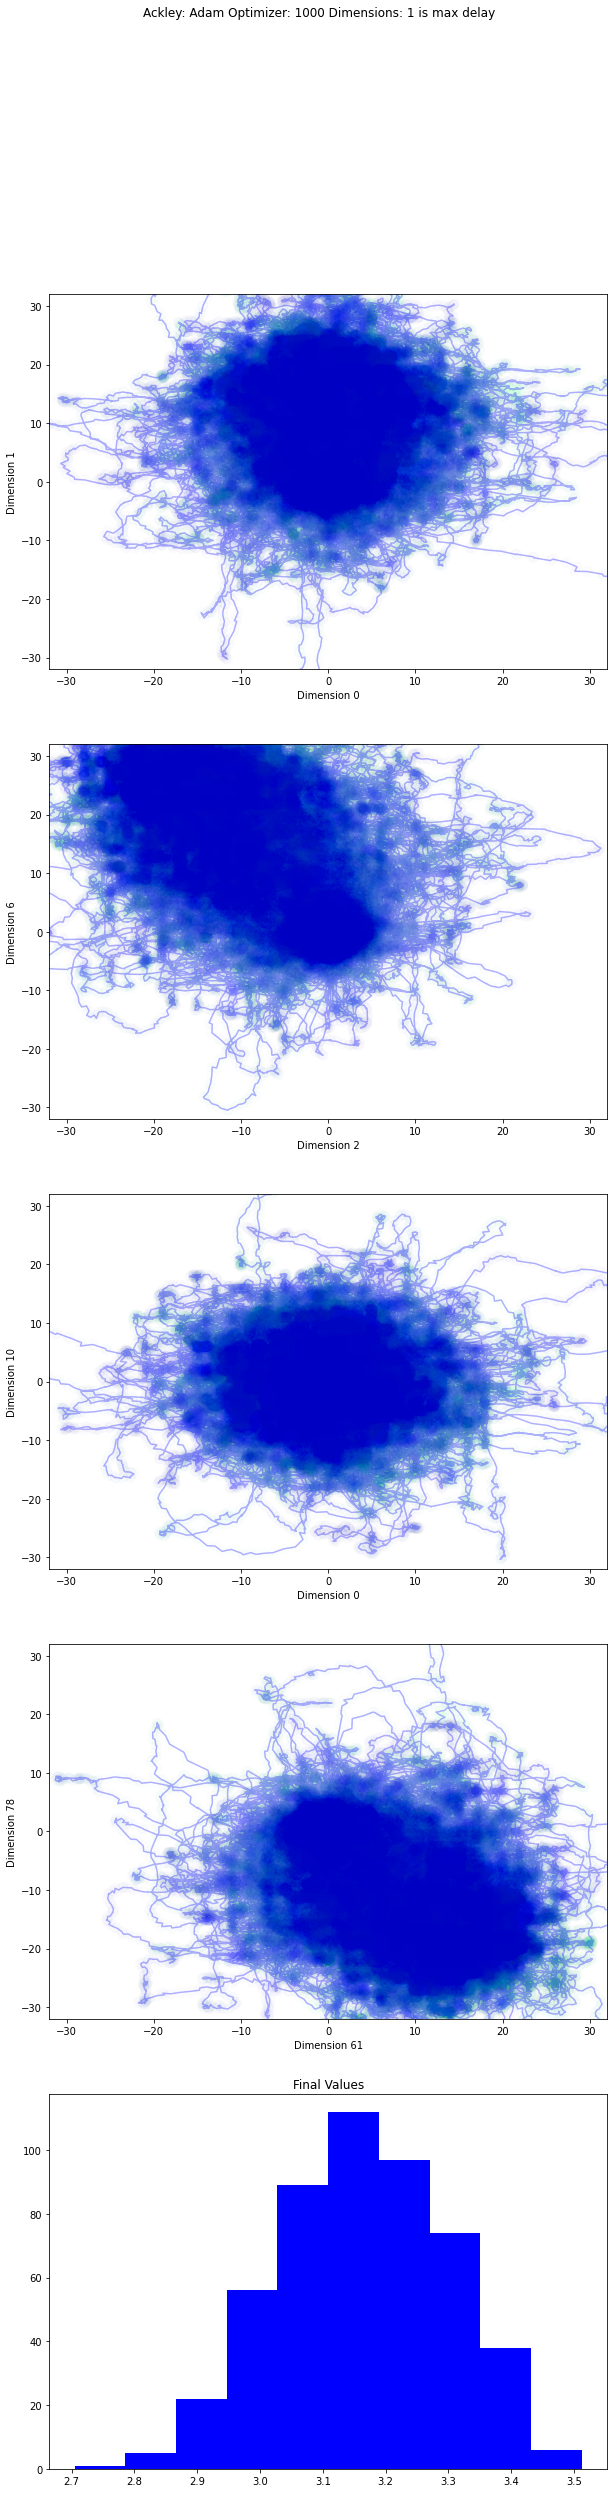

In [71]:
optimizer_path_tracker(num_points=500, do_both=False, type_test='same', n=1000, type_plot='loss', colorbar=False, time_plot=True)

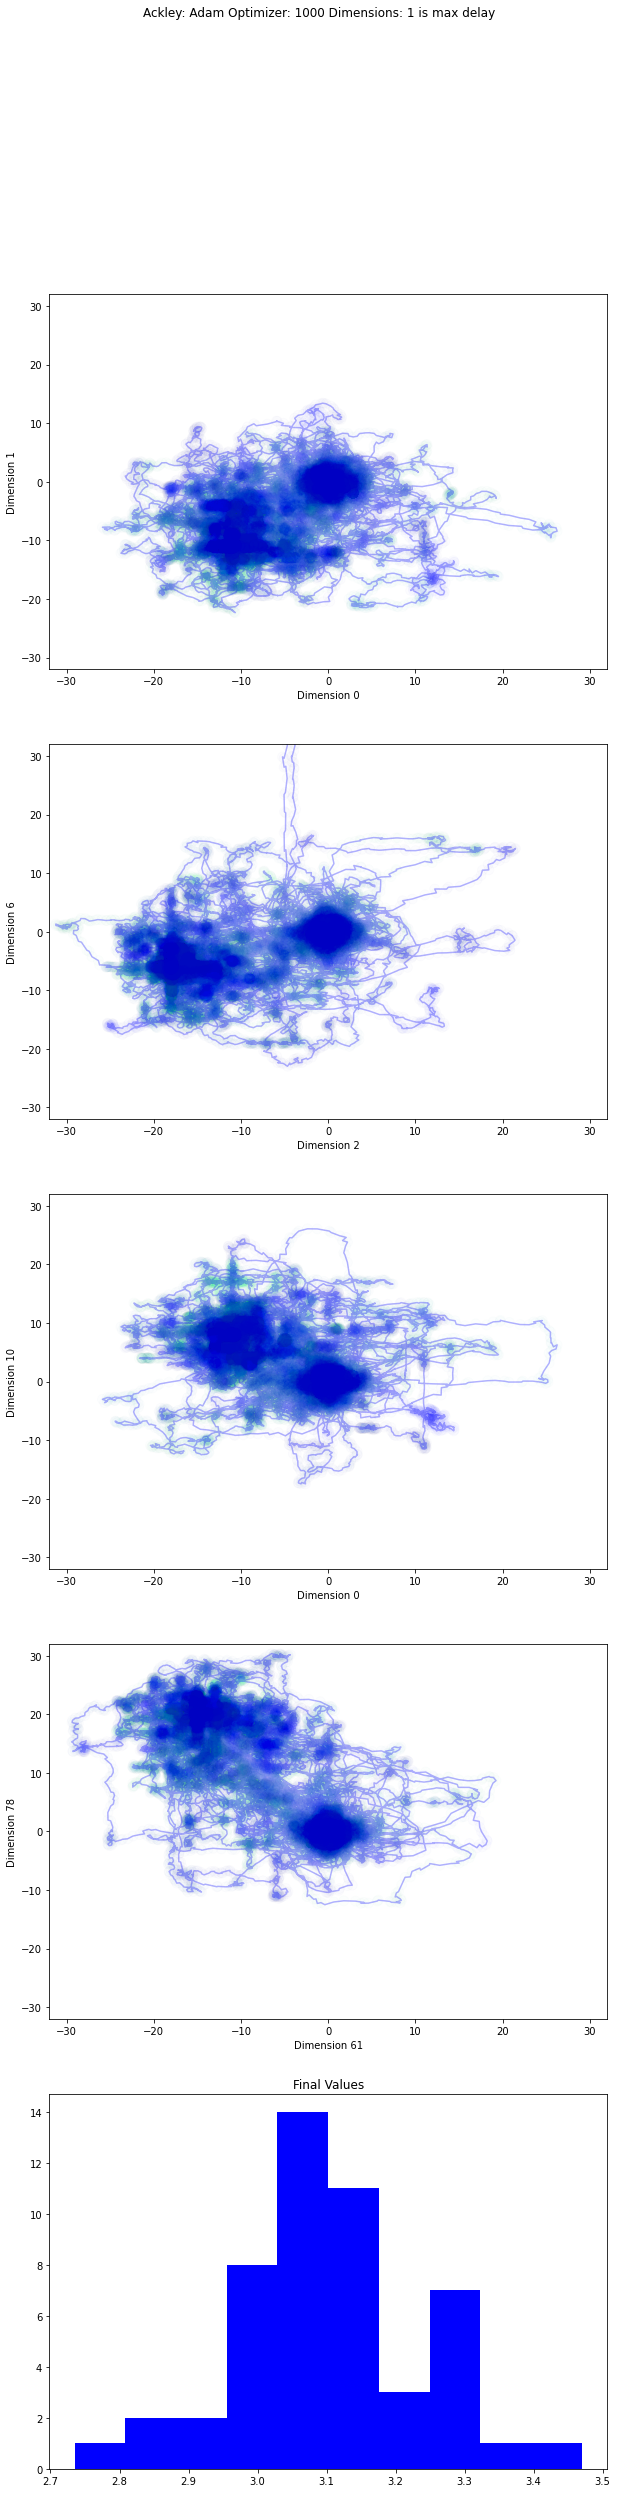

In [68]:
optimizer_path_tracker(num_points=50, do_both=False, type_test='same', n=1000, type_plot='loss', colorbar=False, time_plot=True)

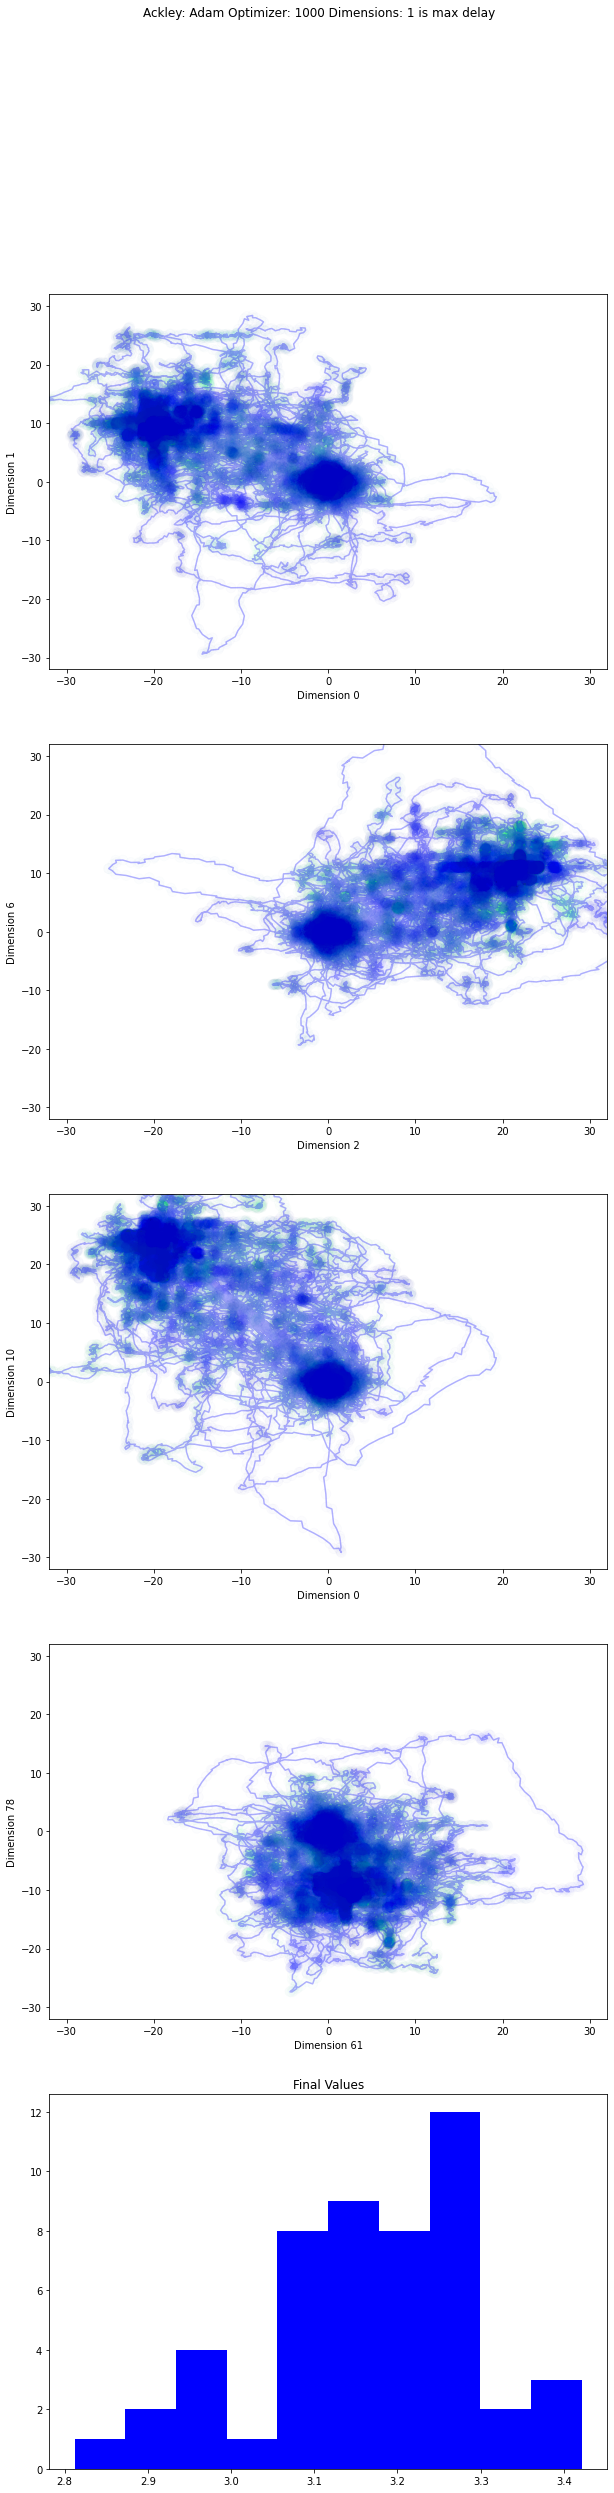

In [67]:
optimizer_path_tracker(num_points=50, do_both=False, type_test='same', n=1000, type_plot='loss', colorbar=False, time_plot=True)